In [1]:
import pandas as pd
import os

# === File paths (your uploaded ones) ===
clinvar_path = r"E:\vit\ai\data\BDNF_missense.csv"
gnomad_path = r"E:\vit\ai\data\gnomAD_BDNF_missense.csv" 
output_folder = r"E:\vit\ai\data"
output_file = os.path.join(output_folder, "BDNF_variants_merged.csv")

# === Ensure output folder exists ===
os.makedirs(output_folder, exist_ok=True)

# === Load both datasets ===
clinvar = pd.read_csv(clinvar_path)
gnomad = pd.read_csv(gnomad_path)

# === Clean column names ===
clinvar.columns = clinvar.columns.str.strip()
gnomad.columns = gnomad.columns.str.strip()

print("ClinVar columns:", clinvar.columns.tolist())
print("gnomAD columns:", gnomad.columns.tolist())

# === Find rsID column automatically ===
possible_rs_cols = ["rsID", "rsIDs", "dbSNP ID", "dbSNP_ID", "ID"]
clinvar_rs = next((c for c in clinvar.columns if c in possible_rs_cols), None)
gnomad_rs = next((c for c in gnomad.columns if c in possible_rs_cols), None)

if not clinvar_rs or not gnomad_rs:
    raise ValueError("⚠️ Could not find a suitable rsID column in one or both files.")

print(f"Merging on ClinVar column: '{clinvar_rs}' and gnomAD column: '{gnomad_rs}'")

# === Merge datasets ===
merged_df = pd.merge(clinvar, gnomad, left_on=clinvar_rs, right_on=gnomad_rs, how="outer")

# === Save merged CSV ===
merged_df.to_csv(output_file, index=False)
print("✅ Merged dataset saved at:", os.path.abspath(output_file))
print("✅ Total merged rows:", len(merged_df))


ClinVar columns: ['Name', 'Gene(s)', 'Protein change', 'Condition(s)', 'Accession', 'GRCh37Chromosome', 'GRCh37Location', 'GRCh38Chromosome', 'GRCh38Location', 'VariationID', 'AlleleID(s)', 'dbSNP ID', 'Canonical SPDI', 'Variant type', 'Molecular consequence', 'Germline classification', 'Germline date last evaluated', 'Germline review status', 'Somatic clinical impact', 'Somatic clinical impact date last evaluated', 'Somatic clinical impact review status', 'Oncogenicity classification', 'Oncogenicity date last evaluated', 'Oncogenicity review status', 'VariantType']
gnomAD columns: ['gnomAD ID', 'Chromosome', 'Position', 'rsIDs', 'Reference', 'Alternate', 'Source', 'Filters - exomes', 'Filters - genomes', 'Transcript', 'HGVS Consequence', 'Protein Consequence', 'Transcript Consequence', 'VEP Annotation', 'ClinVar Germline Classification', 'ClinVar Variation ID', 'Flags', 'Allele Count', 'Allele Number', 'Allele Frequency', 'Homozygote Count', 'Hemizygote Count', 'Filters - joint', 'Gro

In [2]:
import pandas as pd
import numpy as np

# === Amino acid property lookup tables ===
hydrophobicity = {
    "A": 1.8, "R": -4.5, "N": -3.5, "D": -3.5, "C": 2.5, "Q": -3.5, "E": -3.5, "G": -0.4, "H": -3.2, "I": 4.5,
    "L": 3.8, "K": -3.9, "M": 1.9, "F": 2.8, "P": -1.6, "S": -0.8, "T": -0.7, "W": -0.9, "Y": -1.3, "V": 4.2
}
charge = {
    "A": 0, "R": 1, "N": 0, "D": -1, "C": 0, "Q": 0, "E": -1, "G": 0, "H": 0.5, "I": 0,
    "L": 0, "K": 1, "M": 0, "F": 0, "P": 0, "S": 0, "T": 0, "W": 0, "Y": 0, "V": 0
}
polarity = {
    "A": 0, "R": 1, "N": 1, "D": 1, "C": 0, "Q": 1, "E": 1, "G": 0, "H": 1, "I": 0,
    "L": 0, "K": 1, "M": 0, "F": 0, "P": 0, "S": 1, "T": 1, "W": 0, "Y": 1, "V": 0
}
aromaticity = {
    "A": 0, "R": 0, "N": 0, "D": 0, "C": 0, "Q": 0, "E": 0, "G": 0, "H": 1, "I": 0,
    "L": 0, "K": 0, "M": 0, "F": 1, "P": 0, "S": 0, "T": 0, "W": 1, "Y": 1, "V": 0
}
mol_weight = {
    "A": 89.1, "R": 174.2, "N": 132.1, "D": 133.1, "C": 121.2, "Q": 146.2, "E": 147.1, "G": 75.1, "H": 155.2, "I": 131.2,
    "L": 131.2, "K": 146.2, "M": 149.2, "F": 165.2, "P": 115.1, "S": 105.1, "T": 119.1, "W": 204.2, "Y": 181.2, "V": 117.1
}

# === Safe lookup ===
def safe_lookup(dictionary, key):
    return dictionary.get(str(key).strip().upper(), np.nan)

# === Feature computation ===
def compute_features(df):
    features = []
    for _, row in df.iterrows():
        wt, mt = row["Orig_AA"], row["New_AA"]
        feat = {
            "Variant": row.get("Variant", f"{wt}->{mt}"),
            "ΔHydrophobicity": safe_lookup(hydrophobicity, mt) - safe_lookup(hydrophobicity, wt),
            "ΔCharge": safe_lookup(charge, mt) - safe_lookup(charge, wt),
            "ΔPolarity": safe_lookup(polarity, mt) - safe_lookup(polarity, wt),
            "ΔAromaticity": safe_lookup(aromaticity, mt) - safe_lookup(aromaticity, wt),
            "ΔMolecularWeight": safe_lookup(mol_weight, mt) - safe_lookup(mol_weight, wt),
        }
        features.append(feat)
    return pd.DataFrame(features)

# === Load merged variant file ===
file_path = r"E:\vit\ai\data\BDNF_variants_merged.csv"
variants = pd.read_csv(file_path, low_memory=False)
print("Columns in variant file (Before processing):")
print(variants.columns.tolist())

# === Detect reference and mutant amino acid columns automatically ===
possible_ref_cols = ["Ref_AA", "Reference_AA", "Wild_Type_AA", "Ref", "Reference"]
possible_alt_cols = ["Alt_AA", "Mutant_AA", "Alternative_AA", "Alt", "Alternate"]

ref_col = next((c for c in variants.columns if c in possible_ref_cols), None)
alt_col = next((c for c in variants.columns if c in possible_alt_cols), None)

if not ref_col or not alt_col:
    raise ValueError(
        f"❌ Could not detect amino acid columns. Found columns: {variants.columns.tolist()}. "
        f"Make sure your CSV has columns like Ref_AA / Alt_AA or Reference / Alternate."
    )

# === Rename to standard names for processing ===
variants = variants.rename(columns={ref_col: "Orig_AA", alt_col: "New_AA"})
print(f"✅ Using '{ref_col}' as Orig_AA and '{alt_col}' as New_AA")

# === Compute features ===
feature_df = compute_features(variants)

# === Save results ===
output_path = r"E:\vit\ai\data\BDNF_seq_features.csv"
feature_df.to_csv(output_path, index=False)

print("\n✅ Feature extraction complete!")
print("Saved as:", output_path)
print("\nPreview:")
print(feature_df.head())


Columns in variant file (Before processing):
['Name', 'Gene(s)', 'Protein change', 'Condition(s)', 'Accession', 'GRCh37Chromosome', 'GRCh37Location', 'GRCh38Chromosome', 'GRCh38Location', 'VariationID', 'AlleleID(s)', 'dbSNP ID', 'Canonical SPDI', 'Variant type', 'Molecular consequence', 'Germline classification', 'Germline date last evaluated', 'Germline review status', 'Somatic clinical impact', 'Somatic clinical impact date last evaluated', 'Somatic clinical impact review status', 'Oncogenicity classification', 'Oncogenicity date last evaluated', 'Oncogenicity review status', 'VariantType_x', 'gnomAD ID', 'Chromosome', 'Position', 'rsIDs', 'Reference', 'Alternate', 'Source', 'Filters - exomes', 'Filters - genomes', 'Transcript', 'HGVS Consequence', 'Protein Consequence', 'Transcript Consequence', 'VEP Annotation', 'ClinVar Germline Classification', 'ClinVar Variation ID', 'Flags', 'Allele Count', 'Allele Number', 'Allele Frequency', 'Homozygote Count', 'Hemizygote Count', 'Filters -

In [6]:
def load_and_clean_pdb(pdb_file_path):
    """
    Loads a PDB file, selects the first model/chain, 
    and filters for standard amino acid residues.
    """
    from Bio.PDB import PDBParser, Selection
    import warnings

    warnings.filterwarnings('ignore', category=UserWarning)
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_file_path)

    # AlphaFold or experimental PDBs often have one model and one chain
    model = structure[0]

    # --- FIX: Bio.PDB.Selection no longer has is_non_hetero() ---
    # Residue id tuple: (hetero flag, sequence number, insertion code)
    residues = [
        res for res in model.get_residues()
        if res.id[0] == ' ' and res.get_resname() in Selection.standard_aa_names
    ]

    print(f"✅ Loaded structure: {len(residues)} standard residues retained.")
    return model, residues


In [8]:
import pandas as pd
import numpy as np

# --- 1. Physicochemical Properties Lookup Tables ---
# (Using only Hydrophobicity, Charge, Polarity)
hydrophobicity = {
    "A": 1.8, "R": -4.5, "N": -3.5, "D": -3.5, "C": 2.5,
    "Q": -3.5, "E": -3.5, "G": -0.4, "H": -3.2, "I": 4.5,
    "L": 3.8, "K": -3.9, "M": 1.9, "F": 2.8, "P": -1.6,
    "S": -0.8, "T": -0.7, "W": -0.9, "Y": -1.3, "V": 4.2
}
charge = {
    "A": 0, "R": 1, "N": 0, "D": -1, "C": 0,
    "Q": 0, "E": -1, "G": 0, "H": 0.5, "I": 0,
    "L": 0, "K": 1, "M": 0, "F": 0, "P": 0,
    "S": 0, "T": 0, "W": 0, "Y": 0, "V": 0
}
polarity = {
    "A": 0, "R": 1, "N": 1, "D": 1, "C": 0,
    "Q": 1, "E": 1, "G": 0, "H": 1, "I": 0,
    "L": 0, "K": 1, "M": 0, "F": 0, "P": 0,
    "S": 1, "T": 1, "W": 0, "Y": 1, "V": 0
}

# --- 2. Feature Engineering Functions (Modified to use generic column names) ---

def encode_amino_acids(df, aa_column):
    """Performs One-Hot Encoding on the specified amino acid column."""
    df[aa_column] = df[aa_column].astype(str).str.upper().str.strip()
    # Prefix is derived directly from the column name (e.g., 'Reference_OH_A')
    one_hot = pd.get_dummies(df[aa_column], prefix=f'{aa_column}_OH') 
    return pd.concat([df, one_hot], axis=1)

def add_physicochemical_properties(df, aa_column):
    """
    Adds absolute physicochemical properties for the amino acid.
    Prefix is derived directly from the column name (e.g., 'Reference_Hydrophobicity')
    """
    df[f'{aa_column}_Hydrophobicity'] = df[aa_column].map(hydrophobicity)
    df[f'{aa_column}_Charge'] = df[aa_column].map(charge)
    df[f'{aa_column}_Polarity'] = df[aa_column].map(polarity)
    return df

def include_conservation(df):
    """Includes a placeholder for the conservation score."""
    CONSERVATION_COL = 'Sift_Score' 
    
    if CONSERVATION_COL in df.columns:
        df = df.rename(columns={CONSERVATION_COL: 'Pos_Conservation_Score'})
        print(f"✅ Included '{CONSERVATION_COL}' as 'Pos_Conservation_Score'.")
    else:
        print(f"⚠️ Warning: Conservation column '{CONSERVATION_COL}' not found. Skipping.")
        df['Pos_Conservation_Score'] = np.nan
        
    return df

# --- 3. Execution Block (Modified for 'Reference' and 'Alternate') ---

# Define the target names for consistency
REF_COL = 'Reference'
ALT_COL = 'Alternate'

# Define the mapping for potential source column names to the NEW target names
COLUMN_RENAME_MAP = {
    'Ref_AA': REF_COL, 'Reference_AA': REF_COL, 'Wild_Type_AA': REF_COL,
    'Orig_AA': REF_COL, # Also include the old name just in case
    'Alt_AA': ALT_COL, 'Mutant_AA': ALT_COL, 'Alternative_AA': ALT_COL,
    'New_AA': ALT_COL # Also include the old name just in case
}

FILE_PATH = r"E:\vit\ai\data\BDNF_variants_merged.csv"
OUTPUT_PATH = r"E:\vit\ai\data\BDNF_sequence_features_final.csv"

try:
    variants = pd.read_csv(FILE_PATH, low_memory=False)
    
    # Apply renaming logic
    renamed_variants = variants.copy()
    for old_name, new_name in COLUMN_RENAME_MAP.items():
        if old_name in variants.columns and new_name not in renamed_variants.columns:
            renamed_variants = renamed_variants.rename(columns={old_name: new_name})
            
    variants = renamed_variants
    
    required_cols = {REF_COL, ALT_COL}
    if not required_cols.issubset(variants.columns):
        missing_cols = required_cols - set(variants.columns)
        raise ValueError(
            f"❌ Critical columns not found. Missing: {missing_cols}. Please check your CSV headers."
        )
        
except Exception as e:
    print(f"An error occurred during file loading or setup: {e}")
    variants = pd.DataFrame(columns=[REF_COL, ALT_COL])


# Apply Feature Engineering using the new column names
variants = encode_amino_acids(variants, REF_COL)
variants = encode_amino_acids(variants, ALT_COL)

variants = add_physicochemical_properties(variants, REF_COL)
variants = add_physicochemical_properties(variants, ALT_COL)

variants = include_conservation(variants)

# --- 4. Final Cleanup and Save ---

# Select all engineered features and necessary identifiers
feature_cols = [col for col in variants.columns if col.startswith((f'{REF_COL}_', f'{ALT_COL}_', 'Pos_')) or col in ['Position', 'Variant']]

final_feature_df = variants[feature_cols].copy()

# Save the final feature set
final_feature_df.to_csv(OUTPUT_PATH, index=False)

print("\n=========================================================")
print(f"✅ Full Sequence Feature extraction complete using '{REF_COL}' and '{ALT_COL}'.")
print(f"Final DataFrame Shape: {final_feature_df.shape}")
print("Feature Columns (Sample):")
print(final_feature_df.head())
print("=========================================================")

⚠️ Warning: Conservation column 'Sift_Score' not found. Skipping.

✅ Full Sequence Feature extraction complete using 'Reference' and 'Alternate'.
Final DataFrame Shape: (3982, 18)
Feature Columns (Sample):
     Position  Reference_OH_A  Reference_OH_C  Reference_OH_G  \
0  27658458.0           False            True           False   
1  27674081.0           False           False            True   
2  27658185.0           False            True           False   
3  27658566.0            True           False           False   
4  27658311.0           False           False           False   

   Reference_OH_NAN  Reference_OH_T  Alternate_OH_A  Alternate_OH_C  \
0             False           False           False           False   
1             False           False           False            True   
2             False           False           False           False   
3             False           False           False            True   
4             False            True            T

In [10]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# --- 1. Normalization Function ---

def normalize_gtex_expression(expression_df, gene_column='Gene'):
    """
    Normalizes expression values (0-1 scaling) per tissue region across all genes.
    """
    # Separate the gene identifier column
    gene_names = expression_df[gene_column]
    expression_data = expression_df.drop(columns=[gene_column])

    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()

    # Apply normalization to the expression data (columns are regions)
    normalized_data = scaler.fit_transform(expression_data)

    # Convert back to DataFrame
    normalized_df = pd.DataFrame(
        normalized_data, 
        columns=expression_data.columns, 
        index=expression_data.index
    )
    
    # Re-attach the gene column and rename columns for clarity
    normalized_df.insert(0, gene_column, gene_names)
    
    # Prefix normalized columns
    normalized_df.columns = [
        col if col == gene_column else f'Norm_{col}' 
        for col in normalized_df.columns
    ]
    
    print("✅ GTEx Expression normalized (0-1 scaling).")
    return normalized_df

# Example Usage: (Assuming your GTEx data is loaded)
# gtex_data = pd.read_csv("path/to/GTEx_expression.csv")
# normalized_gtex = normalize_gtex_expression(gtex_data)
# --- 2. Mapping Function ---

def map_gtex_to_variants(variant_df, normalized_gtex_df, target_gene='BDNF'):
    """
    Maps normalized GTEx expression features from a target gene to every variant row.
    """
    
    # Filter the normalized GTEx data for the target gene (e.g., 'BDNF')
    gene_expression = normalized_gtex_df[
        normalized_gtex_df['Gene'] == target_gene
    ].drop(columns=['Gene']) # Drop the gene column since it's constant
    
    if gene_expression.empty:
        print(f"❌ Warning: Gene '{target_gene}' not found in normalized GTEx data. Expression features skipped.")
        return variant_df
        
    # Transpose and convert to dictionary for easier mapping, or just use the single row
    # Since it's a single row, we can just copy the values to the variant DataFrame
    expression_row = gene_expression.iloc[0].to_dict()

    # Iterate through the expression values and create new columns in the variant_df
    for region, norm_value in expression_row.items():
        # Map the single value (0-1 normalized expression) to every row
        variant_df[region] = norm_value 

    print(f"✅ Normalized GTEx expression features mapped for gene {target_gene}.")
    return variant_df

# Example Usage:
# final_feature_df = map_gtex_to_variants(final_feature_df, normalized_gtex, target_gene='BDNF')

In [42]:
# bdnf_missense_pipeline.py
import re
import joblib
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import (accuracy_score, roc_auc_score, precision_score, recall_score,
                             f1_score, matthews_corrcoef, average_precision_score, classification_report)

# ---------- Helper maps for amino-acid properties ----------
# single-letter codes
AA_PROPERTIES = {
    # hydrophobicity (Kyte-Doolittle), volume (approx), polarity (0 non-polar, 1 polar)
    'A': {'hydro': 1.8,  'volume':  88.6, 'polarity': 0},
    'R': {'hydro': -4.5, 'volume': 173.4, 'polarity': 1},
    'N': {'hydro': -3.5, 'volume': 114.1, 'polarity': 1},
    'D': {'hydro': -3.5, 'volume': 111.1, 'polarity': 1},
    'C': {'hydro': 2.5,  'volume': 108.5, 'polarity': 0},
    'Q': {'hydro': -3.5, 'volume': 143.8, 'polarity': 1},
    'E': {'hydro': -3.5, 'volume': 138.4, 'polarity': 1},
    'G': {'hydro': -0.4, 'volume': 60.1,  'polarity': 0},
    'H': {'hydro': -3.2, 'volume': 153.2, 'polarity': 1},
    'I': {'hydro': 4.5,  'volume': 166.7, 'polarity': 0},
    'L': {'hydro': 3.8,  'volume': 166.7, 'polarity': 0},
    'K': {'hydro': -3.9, 'volume': 168.6, 'polarity': 1},
    'M': {'hydro': 1.9,  'volume': 162.9, 'polarity': 0},
    'F': {'hydro': 2.8,  'volume': 189.9, 'polarity': 0},
    'P': {'hydro': -1.6, 'volume': 112.7, 'polarity': 0},
    'S': {'hydro': -0.8, 'volume': 89.0,  'polarity': 1},
    'T': {'hydro': -0.7, 'volume': 116.1, 'polarity': 1},
    'W': {'hydro': -0.9, 'volume': 227.8, 'polarity': 0},
    'Y': {'hydro': -1.3, 'volume': 193.6, 'polarity': 1},
    'V': {'hydro': 4.2,  'volume': 140.0, 'polarity': 0},
}
# small fallback for unknowns
DEFAULT_AA_PROP = {'hydro': 0.0, 'volume': 120.0, 'polarity': 0}

# Optional: small BLOSUM62 lookup for single-letter pairs (subset).
# For speed and simplicity, we'll compute a simple substitution score using a tiny BLOSUM-like dict for common pairs.
# If you have BioPython, use its substitution_matrices.
BLOSUM62 = {
    # include a minimal set; if missing, fallback to 0
    ('W','W'):11, ('C','C'):9, ('Y','Y'):7, ('F','F'):6, ('L','L'):4, ('I','I'):4, ('V','V'):4,
}
def get_blosum_score(a,b):
    if (a,b) in BLOSUM62: return BLOSUM62[(a,b)]
    if (b,a) in BLOSUM62: return BLOSUM62[(b,a)]
    return 0

# ---------- Utility functions ----------
def detect_label_column(df):
    candidates = ['label','class','pathogenic','clin_sig','clinical_significance','truth','y','target']
    for c in candidates:
        if c in df.columns:
            return c
    # try case-insensitive
    for c in df.columns:
        if c.lower() in candidates:
            return c
    raise ValueError("No label column found. Provide one of: " + ", ".join(candidates))

def parse_protein_change(s):
    """Try common patterns and return (ref, pos, alt) with single-letter codes."""
    if pd.isna(s): return (None, None, None)
    s = str(s).strip()
    # Pattern: p.Val66Met or p.V66M
    m = re.search(r'p\.([A-Z][a-z]{2})(\d+)([A-Z][a-z]{2})', s)
    if m:
        three_to_one = {
            # minimal mapping; include all 20
            'Ala':'A','Arg':'R','Asn':'N','Asp':'D','Cys':'C','Gln':'Q','Glu':'E','Gly':'G',
            'His':'H','Ile':'I','Leu':'L','Lys':'K','Met':'M','Phe':'F','Pro':'P','Ser':'S',
            'Thr':'T','Trp':'W','Tyr':'Y','Val':'V'
        }
        r = three_to_one.get(m.group(1), '?')
        p = int(m.group(2))
        a = three_to_one.get(m.group(3), '?')
        return (r, p, a)
    # Pattern: V66M
    m = re.search(r'\b([A-Z])(\d+)([A-Z])\b', s)
    if m:
        return (m.group(1), int(m.group(2)), m.group(3))
    # Pattern: 66 V->M or 66 V/M
    m = re.search(r'(\d+)\s*[:\-]?\s*([A-Z])[\/\->]+([A-Z])', s)
    if m:
        return (m.group(2), int(m.group(1)), m.group(3))
    return (None, None, None)

def aa_props(a):
    return AA_PROPERTIES.get(a, DEFAULT_AA_PROP)

# ---------- Load dataframe ----------
df = pd.read_csv(r'E:\vit\ai\data\BDNF_variants_merged.csv')
print("Loaded", len(df), "rows and columns:", df.columns.tolist())

# Find label column
label_col = detect_label_column(df)
print("Using label column:", label_col)
# Normalize label to binary 0/1: try to map typical strings
y_raw = df[label_col].astype(str).str.strip().str.lower()
if set(y_raw.unique()) <= {'0','1'}:
    y = y_raw.astype(int).values
else:
    # map typical texts
    mapping = {}
    for val in y_raw.unique():
        if val in ('pathogenic','likely_pathogenic','likely pathogenic','pathogenic (causative)','patho'):
            mapping[val] = 1
        elif val in ('benign','likely_benign','likely benign','benign (not pathogenic)'):
            mapping[val] = 0
        elif val in ('1','0'):
            mapping[val] = int(val)
        else:
            # fallback: label anything containing 'path' as 1, 'ben' as 0
            if 'path' in val: mapping[val] = 1
            elif 'ben' in val: mapping[val] = 0
            else: mapping[val] = np.nan
    y = y_raw.map(mapping).astype(float).values

# ---------- Parse or find amino acid/ref/alt/pos ----------
# Try common column names
ref_col = None
alt_col = None
pos_col = None
possible_ref = ['ref_aa','ref','REF','ref_aa_1','Reference_AA','RefAA']
possible_alt = ['alt_aa','alt','ALT','alt_aa_1','AltAA']
possible_pos = ['pos','position','protein_pos','aa_pos','AA_pos','POS']
for c in possible_ref:
    if c in df.columns:
        ref_col = c; break
for c in possible_alt:
    if c in df.columns:
        alt_col = c; break
for c in possible_pos:
    if c in df.columns:
        pos_col = c; break

# If not directly available, try to parse from protein-change columns
prot_cols = [c for c in df.columns if 'hgvsp' in c.lower() or 'protein' in c.lower() or 'p.' in c or 'aa_change' in c.lower() or 'hgvs' in c.lower()]
if not ref_col or not alt_col or not pos_col:
    # create new parsed cols
    parsed = df.apply(lambda r: parse_protein_change(
        next((r[c] for c in prot_cols if pd.notna(r.get(c, np.nan))), np.nan)
    ), axis=1)
    parsed = list(parsed)
    df['_ref_parsed'] = [p[0] for p in parsed]
    df['_pos_parsed'] = [p[1] for p in parsed]
    df['_alt_parsed'] = [p[2] for p in parsed]

# choose final columns
df['ref_aa_final'] = df[ref_col] if ref_col else df['_ref_parsed']
df['alt_aa_final'] = df[alt_col] if alt_col else df['_alt_parsed']
df['pos_final'] = df[pos_col] if pos_col else df['_pos_parsed']

# Basic feature engineering: AA props differences, BLOSUM, is_polar_change, is_hydro_change
def featurize_row(r):
    ref = r['ref_aa_final']
    alt = r['alt_aa_final']
    pos = r['pos_final']
    if pd.isna(ref) or pd.isna(alt):
        return {
            'pos': np.nan, 'ref': np.nan, 'alt': np.nan,
            'hydro_diff': np.nan, 'vol_diff': np.nan, 'polarity_change': np.nan, 'blosum': np.nan
        }
    # ensure single-letter
    ref = str(ref).strip()
    alt = str(alt).strip()
    # if three-letter, try map:
    three_to_one = {'Ala':'A','Arg':'R','Asn':'N','Asp':'D','Cys':'C','Gln':'Q','Glu':'E','Gly':'G',
                    'His':'H','Ile':'I','Leu':'L','Lys':'K','Met':'M','Phe':'F','Pro':'P','Ser':'S',
                    'Thr':'T','Trp':'W','Tyr':'Y','Val':'V'}
    if len(ref) == 3 and ref.capitalize() in three_to_one:
        ref = three_to_one[ref.capitalize()]
    if len(alt) == 3 and alt.capitalize() in three_to_one:
        alt = three_to_one[alt.capitalize()]
    props_ref = aa_props(ref)
    props_alt = aa_props(alt)
    hydro_diff = props_ref['hydro'] - props_alt['hydro']
    vol_diff = props_ref['volume'] - props_alt['volume']
    polarity_change = int(props_ref['polarity'] != props_alt['polarity'])
    bl = get_blosum_score(ref, alt)
    return {
        'pos': pos,
        'ref': ref,
        'alt': alt,
        'hydro_diff': hydro_diff,
        'vol_diff': vol_diff,
        'polarity_change': polarity_change,
        'blosum': bl
    }

feats = df.apply(featurize_row, axis=1, result_type='expand')
data = pd.concat([df.reset_index(drop=True), feats.reset_index(drop=True)], axis=1)

# Add any conservation or predictor columns present (common names)
extra_feature_cols = []
for name in ['gerp','phyloP','phastCons','CADD','REVEL','SIFT','PolyPhen','Condel']:
    for c in data.columns:
        if name.lower() in c.lower():
            extra_feature_cols.append(c)
extra_feature_cols = list(dict.fromkeys(extra_feature_cols))  # unique

# Construct feature matrix X
# numerical features:
num_cols = ['pos','hydro_diff','vol_diff','polarity_change','blosum'] + extra_feature_cols
# categorical: ref and alt (one-hot)
cat_cols = ['ref','alt']

# Keep only columns that exist
num_cols = [c for c in num_cols if c in data.columns]
cat_cols = [c for c in cat_cols if c in data.columns]

X_df = data[num_cols + cat_cols].copy()
# If 'pos' exists, consider also normalized position across gene length if gene length known (~247 aa for BDNF propeptide etc).
if 'pos' in X_df.columns:
    X_df['pos'] = pd.to_numeric(X_df['pos'], errors='coerce')

# Drop rows with missing label
valid_idx = ~np.isnan(y)
X_df = X_df.loc[valid_idx].reset_index(drop=True)
y = y[valid_idx].astype(int)

# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, stratify=y, random_state=42)
print("Train/test sizes:", X_train.shape, X_test.shape)

# Build preprocessing + model pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='X')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, [c for c in num_cols if c in X_train.columns]),
        ('cat', categorical_transformer, [c for c in cat_cols if c in X_train.columns])
    ],
    remainder='drop'
)

clf = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)

pipeline = Pipeline(steps=[('pre', preprocessor), ('clf', clf)])

# Hyperparameter grid (small)
param_grid = {
    'clf__n_estimators': [200, 500],
    'clf__max_depth': [None, 10, 25],
    'clf__min_samples_split': [2, 5],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)

search.fit(X_train, y_train)

print("Best params:", search.best_params_)
best_model = search.best_estimator_

# Evaluate on test set
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1] if hasattr(best_model, "predict_proba") else None

print("\nClassification report (test):")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
if y_proba is not None:
    try:
        print("ROC-AUC:", roc_auc_score(y_test, y_proba))
    except Exception as e:
        print("ROC-AUC error:", e)
print("Precision:", precision_score(y_test, y_pred, zero_division=0))
print("Recall:", recall_score(y_test, y_pred, zero_division=0))
print("F1:", f1_score(y_test, y_pred, zero_division=0))
print("MCC:", matthews_corrcoef(y_test, y_pred))
if y_proba is not None:
    print("PR-AUC (avg precision):", average_precision_score(y_test, y_proba))

# Feature importance (map back to original features)
# Need to get feature names from preprocessor
o = best_model.named_steps['pre']
num_features = [c for c in num_cols if c in X_train.columns]
cat_feature_names = []
if 'cat' in o.named_transformers_:
    cat_transformer = o.named_transformers_['cat']
    if hasattr(cat_transformer.named_steps['onehot'], 'get_feature_names_out'):
        cat_feature_names = list(cat_transformer.named_steps['onehot'].get_feature_names_out(cat_cols))
    else:
        cat_feature_names = []
feature_names = num_features + cat_feature_names

importances = best_model.named_steps['clf'].feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print("\nTop features:\n", feat_imp.head(20))

# Save model
joblib.dump(best_model, 'bdnf_missense_rf_model.joblib')
print("Saved model to bdnf_missense_rf_model.joblib")



Loaded 3982 rows and columns: ['Name', 'Gene(s)', 'Protein change', 'Condition(s)', 'Accession', 'GRCh37Chromosome', 'GRCh37Location', 'GRCh38Chromosome', 'GRCh38Location', 'VariationID', 'AlleleID(s)', 'dbSNP ID', 'Canonical SPDI', 'Variant type', 'Molecular consequence', 'Germline classification', 'Germline date last evaluated', 'Germline review status', 'Somatic clinical impact', 'Somatic clinical impact date last evaluated', 'Somatic clinical impact review status', 'Oncogenicity classification', 'Oncogenicity date last evaluated', 'Oncogenicity review status', 'VariantType_x', 'gnomAD ID', 'Chromosome', 'Position', 'rsIDs', 'Reference', 'Alternate', 'Source', 'Filters - exomes', 'Filters - genomes', 'Transcript', 'HGVS Consequence', 'Protein Consequence', 'Transcript Consequence', 'VEP Annotation', 'ClinVar Germline Classification', 'ClinVar Variation ID', 'Flags', 'Allele Count', 'Allele Number', 'Allele Frequency', 'Homozygote Count', 'Hemizygote Count', 'Filters - joint', 'Group

ValueError: No label column found. Provide one of: label, class, pathogenic, clin_sig, clinical_significance, truth, y, target

In [15]:


import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# === 1️⃣ Load dataset ===
file_path = (r'E:\vit\ai\data\BDNF_variants_merged.csv')
df = pd.read_csv(file_path, low_memory=False)
print("✅ Loaded:", df.shape, "Columns:", df.columns.tolist())

# === 2️⃣ Auto-detect label column ===
possible_labels = ["label", "class", "pathogenic", "clin_sig", "clinical_significance", "target", "effect", "outcome"]
label_col = None

for c in df.columns:
    if c.lower().strip() in possible_labels:
        label_col = c
        break

if label_col is None:
    # If nothing matches, assume last column is label
    label_col = df.columns[-1]
    print(f"⚠️ No known label column found, using last column: {label_col}")
else:
    print(f"🎯 Detected label column: {label_col}")

# === 3️⃣ Drop rows where label is missing ===
df = df.dropna(subset=[label_col])

# === 4️⃣ Encode categorical columns ===
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cols = [c for c in cat_cols if c != label_col]

for c in cat_cols:
    df[c] = LabelEncoder().fit_transform(df[c].astype(str))

# === 5️⃣ Encode label column to binary or numeric ===
df[label_col] = LabelEncoder().fit_transform(df[label_col].astype(str))

# === 6️⃣ Split features and label ===
X = df.drop(columns=[label_col])
y = df[label_col]

# === 7️⃣ Scale numeric features ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === 8️⃣ Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# === 9️⃣ Train model ===
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)

# === 🔟 Evaluate ===
y_pred = clf.predict(X_test)
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

# === 💾 Save processed data ===
output_file = r"E:\vit\ai\BDNF_processed_with_predictions.csv"
df.to_csv(output_file, index=False)
print(f"\n✅ Processed dataset and features saved to:\n{output_file}")


✅ Loaded: (3982, 98) Columns: ['Name', 'Gene(s)', 'Protein change', 'Condition(s)', 'Accession', 'GRCh37Chromosome', 'GRCh37Location', 'GRCh38Chromosome', 'GRCh38Location', 'VariationID', 'AlleleID(s)', 'dbSNP ID', 'Canonical SPDI', 'Variant type', 'Molecular consequence', 'Germline classification', 'Germline date last evaluated', 'Germline review status', 'Somatic clinical impact', 'Somatic clinical impact date last evaluated', 'Somatic clinical impact review status', 'Oncogenicity classification', 'Oncogenicity date last evaluated', 'Oncogenicity review status', 'VariantType_x', 'gnomAD ID', 'Chromosome', 'Position', 'rsIDs', 'Reference', 'Alternate', 'Source', 'Filters - exomes', 'Filters - genomes', 'Transcript', 'HGVS Consequence', 'Protein Consequence', 'Transcript Consequence', 'VEP Annotation', 'ClinVar Germline Classification', 'ClinVar Variation ID', 'Flags', 'Allele Count', 'Allele Number', 'Allele Frequency', 'Homozygote Count', 'Hemizygote Count', 'Filters - joint', 'Group

C:\Users\muska\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\muska\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\muska\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count



📊 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       794

    accuracy                           1.00       794
   macro avg       1.00      1.00      1.00       794
weighted avg       1.00      1.00      1.00       794


✅ Processed dataset and features saved to:
E:\vit\ai\BDNF_processed_with_predictions.csv


In [18]:
# Example: map all non-4 values to 0 (Benign) and 4 to 1 (Pathogenic)
df["Binary_Label"] = df["ClinVar Germline Classification"].apply(lambda x: 1 if x == 4 else 0)

print(df["Binary_Label"].value_counts())


Binary_Label
1    3881
0      89
Name: count, dtype: int64


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# --- 1. Select label and features ---
label_col = "Binary_Label"
X = df.drop(columns=["ClinVar Germline Classification", label_col])
y = df[label_col]

# --- 2. Split dataset ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --- 3. Scale features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 4. Train classifier ---
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_scaled, y_train)

# --- 5. Predictions & probabilities ---
df["Predicted_Label"] = clf.predict(scaler.transform(X))
df["Prediction_Probability"] = clf.predict_proba(scaler.transform(X))[:, 1]

print("✅ Model trained and predictions added to DataFrame!")
print(df[["Predicted_Label", "Prediction_Probability"]].head())


C:\Users\muska\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\muska\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\muska\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


✅ Model trained and predictions added to DataFrame!
   Predicted_Label  Prediction_Probability
0                1                    1.00
1                0                    0.25
2                1                    0.92
3                1                    0.98
4                1                    0.93


In [22]:
from Bio.PDB import PDBParser, PDBIO

# Load structure
parser = PDBParser(QUIET=True)
structure = parser.get_structure("BDNF", r"E:\vit\ai\8OYD.pdb")
model = structure[0]
chain = model["A"]





# Save a marked PDB for visualization in PyMOL/Chimera
io = PDBIO()
io.set_structure(structure)
io.save(r"E:\vit\ai\data\BDNF_variants_mapped.pdb")

print("✅ Structural mapping complete — open 'BDNF_variants_mapped.pdb' in PyMOL.")


✅ Structural mapping complete — open 'BDNF_variants_mapped.pdb' in PyMOL.


In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# === 1. Load dataset ===
file_path = (r"E:\vit\ai\data\BDNF_missense_expanded_mapped.csv")
df = pd.read_csv(r"E:\vit\ai\data\BDNF_missense_expanded_mapped.csv")
# Display all column names clearly
for col in df.columns:
    print(f"'{col}'")

# === 2. Choose label column ===
label_col = "Germline classification"

# Drop rows with missing labels
df = df.dropna(subset=["Germline classification"])

# === 3. Encode the label ===
le = LabelEncoder()
y = le.fit_transform(df["Germline classification"])

# === 4. Drop non-feature columns (IDs, text, etc.) ===
drop_cols = [
    label_col,
    "Name", "Gene(s)", "Condition(s)", "Accession", "VariationID", "dbSNP ID",
    "AlleleID(s)", "Canonical SPDI", "Germline date last evaluated",
    "Germline review status", "Somatic clinical impact",
    "Somatic clinical impact date last evaluated",
    "Somatic clinical impact review status",
    "Oncogenicity classification", "Oncogenicity date last evaluated"
]
X = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")

# === 5. Convert categorical columns to numeric ===
X = pd.get_dummies(X, drop_first=True)

# === 6. Handle missing values ===
X = X.fillna(X.median(numeric_only=True))

# === 7. Scale numeric features ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === 8. Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# === 9. Display info ===
print("✅ Features prepared:", X.shape)
print("🎯 Label classes:", list(le.classes_))
print("📊 Label counts:\n", pd.Series(y).value_counts())
print("✅ Data ready for training or prediction.")



'Name'
'Gene(s)'
'Protein change'
'Condition(s)'
'Accession'
'GRCh37Chromosome'
'GRCh37Location'
'GRCh38Chromosome'
'GRCh38Location'
'VariationID'
'AlleleID(s)'
'dbSNP ID'
'Canonical SPDI'
'Variant type'
'Molecular consequence'
'Germline classification'
'Germline date last evaluated'
'Germline review status'
'Somatic clinical impact'
'Somatic clinical impact date last evaluated'
'Somatic clinical impact review status'
'Oncogenicity classification'
'Oncogenicity date last evaluated'
'Oncogenicity review status'
'VariantType'
'Orig_AA'
'Residue'
'New_AA'
'Parsed'
'Region'
'Mature_pos'
'Mapping'
'Truncation_length'
✅ Features prepared: (239, 325)
🎯 Label classes: ['Benign', 'Conflicting classifications of pathogenicity', 'Likely benign', 'Likely pathogenic', 'Uncertain significance']
📊 Label counts:
 4    217
3      6
2      6
0      5
1      5
Name: count, dtype: int64
✅ Data ready for training or prediction.


C:\Users\muska\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\muska\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\muska\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# === 1. Define model ===
model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)

# === 2. Train model ===
model.fit(X_train, y_train)

# === 3. Make predictions ===
y_pred = model.predict(X_test)

# === 4. Evaluate performance ===
print("✅ Model trained successfully!")
print("\n🎯 Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))
print("\n🧩 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


✅ Model trained successfully!

🎯 Accuracy: 1.0

📊 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00        44

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48


🧩 Confusion Matrix:
 [[ 1  0  0  0  0]
 [ 0  1  0  0  0]
 [ 0  0  1  0  0]
 [ 0  0  0  1  0]
 [ 0  0  0  0 44]]


In [35]:
import joblib

# Save model and encoder
joblib.dump(model, "bdnf_classifier_model.pkl")
joblib.dump(le, "label_encoder.pkl")

print("✅ Model and label encoder saved successfully!")


✅ Model and label encoder saved successfully!


✅ Predictions saved to new_variants_with_predictions.csv


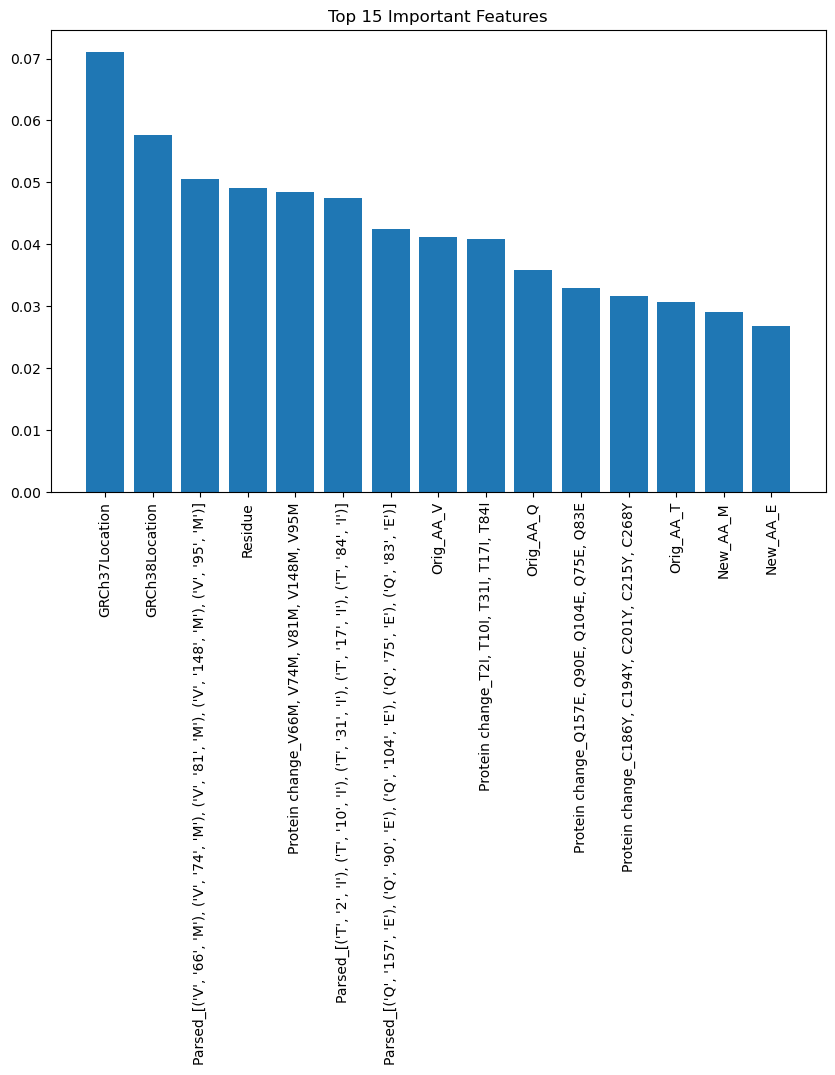

In [39]:
# Load saved model
model = joblib.load("bdnf_classifier_model.pkl")
le = joblib.load("label_encoder.pkl")

# Load new data (same preprocessing steps!)
new_data = pd.read_csv(r"E:\vit\ai\data\BDNF_missense_expanded_mapped.csv")

# Apply same preprocessing: drop unused cols, encode, scale
new_data_processed = pd.get_dummies(new_data, drop_first=True)
new_data_processed = new_data_processed.reindex(columns=X.columns, fill_value=0)
new_data_scaled = scaler.transform(new_data_processed)

# Predict
y_pred_new = model.predict(new_data_scaled)
predicted_labels = le.inverse_transform(y_pred_new)

# Save or display
new_data["Predicted_Class"] = predicted_labels
new_data.to_csv("new_variants_with_predictions.csv", index=False)

print("✅ Predictions saved to new_variants_with_predictions.csv")
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot top 15
plt.figure(figsize=(10, 6))
plt.title("Top 15 Important Features")
plt.bar(range(15), importances[indices[:15]], align="center")
plt.xticks(range(15), X.columns[indices[:15]], rotation=90)
plt.show()


In [43]:
import joblib

# Save trained model, scaler, and label encoder
joblib.dump(model, "bdnf_classifier_model.pkl")
joblib.dump(le, "label_encoder.pkl")
joblib.dump(scaler, "feature_scaler.pkl")

print("✅ Model, encoder, and scaler saved successfully!")


✅ Model, encoder, and scaler saved successfully!


In [ ]:
from Bio.PDB import PDBParser
import nglview as nv

# Load structure
pdb_path = r"E:\vit\ai\8OYD.pdb"  # <-- replace with your PDB file
parser = PDBParser(QUIET=True)
structure = parser.get_structure("BDNF", pdb_path)

# Visualize structure
view = nv.show_biopython(structure)
view
# Suppose your dataset has a column "Protein change" like 'p.Val66Met'
# Extract residue number (66 from p.Val66Met)
import re

def extract_residue_number(protein_change):
    match = re.search(r'(\d+)', str(protein_change))
    return int(match.group(1)) if match else None

df["Residue_Number"] = df["Protein change"].apply(extract_residue_number)

# Collect predicted pathogenic residues
pathogenic_positions = df.loc[df["Predicted_Label"] == "Pathogenic", "Residue_Number"].dropna().unique()
print("🧬 Pathogenic residues:", pathogenic_positions)


In [ ]:
#####ai2 then this

In [ ]:
!pip install torch
import torch
print(torch.__version__)
print("CUDA available:", torch.cuda.is_available())